In [2]:
import numpy as np
import matplotlib.pyplot as plt 
np.random.seed(0)

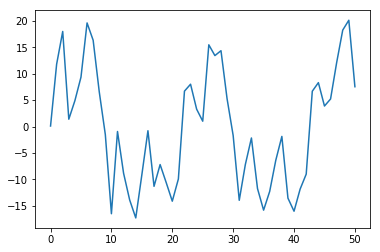

In [3]:
# initial conditions
mu0 = 0
P0 = 2

T = 50 # number of steps
Q = 10 # process noise
R = 1 # measurement noise

# ground truth and measurements
x = np.zeros(T+1)
y = np.zeros(T+1)
x[0] = 0.1
y[0] = 0.05*x[0]**2 + np.random.normal(0, np.sqrt(R))
for k in range(0,T):
    x[k + 1] = 0.5*x[k] + 25*x[k]/(1+x[k]**2) + 8*np.cos(1.2*k) + np.random.normal(0, np.sqrt(Q))
    y[k + 1] = 0.05*x[k+1]**2 + np.random.normal(0, np.sqrt(R))

plt.plot(range(T+1), x)

In [47]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

m0 = 0
p0 = 2
points = MerweScaledSigmaPoints(n=1, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(0, 2)
print(sigmas)

[[ 0.        ]
 [ 0.44497191]
 [-0.44497191]]


In [49]:
# pass sigma points forward
def fx(sigmas, step):
    sigmas_f = np.zeros(len(sigmas))
    for i,s in enumerate(sigmas):
        sigmas_f[i] = 0.5*s + 25*s/(1+s**2) + 8*np.cos(1.2*step) + np.random.normal(0, np.sqrt(Q))
    return sigmas_f

sigmas_f = fx(sigmas, 0)
print(sigmas_f)
print(points.Wm)
print(points.Wc)

[ 6.54034132 17.29241137  3.90985514]
[-9.1010101   5.05050505  5.05050505]
[-6.1910101   5.05050505  5.05050505]


In [50]:
# predict step
xs = []
ps = []
for s, wm in zip(sigmas_f, points.Wm):
    xs.append(wm*s)
ukf_mean = np.mean(xs)
print(ukf_mean)

for s, wc in zip(sigmas_f, points.Wc):
    ps.append(wc*(s-ukf_mean)**2 + Q)
ukf_P = np.mean(ps)
print(ukf_P)

15.852813901666176
74.64808787541422


In [51]:
def hx(sigmas_f):
    sigmas_m = np.zeros(len(sigmas))
    for i,s in enumerate(sigmas_f):
        sigmas_m[i] = 0.05*s**2 + np.random.normal(0, np.sqrt(R))
    return sigmas_m

sigmas_m = hx(sigmas_f)
print(sigmas_m)

[ 1.3940484  14.12493601  0.66589584]


In [52]:
ms = []
pms = []
for s, wm in zip(sigmas_m, points.Wm):
    ms.append(wm*s)
mean_m = np.mean(ms)
print(mean_m)

for s, wc in zip(sigmas_m, points.Wc):
    pms.append(wc*(s-mean_m)**2 + R)
mean_pm = np.mean(pms)
print(mean_pm)

20.671307436970842
-19.974456386275808


In [54]:
residual = y[0] - mean_m
print(y[0])
print(residual)

1.764552345967664
-18.906755091003177
